## Домашнее задание к уроку 6<a class='anchor' id='hw'>

In [1]:
# Загрузка необходимых библиотек

import numpy as np
import random

from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor

from sklearn.datasets import load_diabetes

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
random.seed(42)

---

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [2]:
# Загрузка значений X и y

X, y = load_diabetes(return_X_y = True)

In [3]:
# Разбитие на train и test

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25)

In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])


def mean_squared_error(y_real, prediction):
    
    return (sum((y_real - prediction)**2)) / len(y_real)


def bias(y, z):
    
    return (y - z)


def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = []
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        
        tree = DecisionTreeRegressor(max_depth = max_depth, random_state = 42)

        if len(trees) == 0:

            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
            
        else:

            target = gb_predict(X_train, trees, coefs, eta)
            

            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

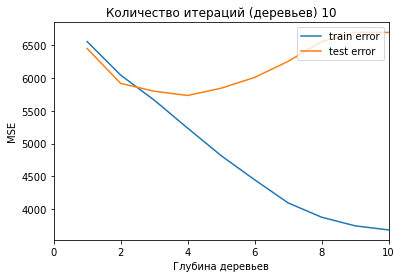

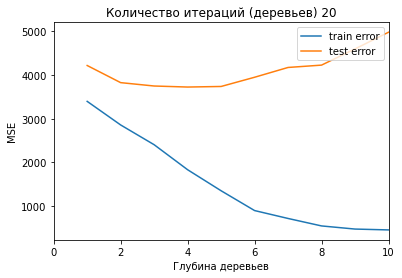

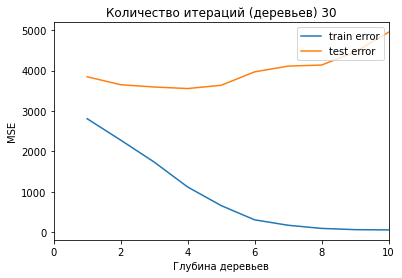

In [5]:
eta = 0.1
max_depth = 10
n_trees = 30

for n in range(10, n_trees+10,10):
    coefs = [1] * n
    A = np.zeros((max_depth, 2))

    for i in range(1, max_depth+1):
        trees, train_errors, test_errors = gb_fit(n, i, X_train, X_test, y_train, y_test, coefs, eta)
        train_prediction = gb_predict(X_train, trees, coefs, eta)
        test_prediction = gb_predict(X_test, trees, coefs, eta)
        A[i-1,0] = mean_squared_error(y_train, train_prediction)
        A[i-1,1] = mean_squared_error(y_test, test_prediction)
    
    plt.title(f'Количество итераций (деревьев) {n}')
    plt.xlabel('Глубина деревьев')
    plt.ylabel('MSE')
    plt.xlim(0, max_depth)
    plt.plot(list(range(1, max_depth+1)), A[:,0], label='train error')
    plt.plot(list(range(1, max_depth+1)), A[:,1], label='test error')
    plt.legend(loc='upper right')
    plt.show()

**Вывод:** при увеличении количества деревьев **MSE** уменьшается на train и test.

2. *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [6]:
def get_bootstrap(X, y):
    
    n_samples = X.shape[0]
    
    # Половина всей выборки
    n_samples_div2 = n_samples // 2
    
    X_data = np.zeros((n_samples_div2, X.shape[1]))
    y_data = np.zeros(n_samples_div2)
        
    for j in range(n_samples_div2):
        
        sample_index = random.randint(0, n_samples-1)
        X_data[j] = X[sample_index]
        y_data[j] = y[sample_index]
        
    return X_data, y_data

In [7]:
def gb_fit2(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):

    trees = []
    
    X_train_copy = X_train.copy()
    y_train_copy = y_train.copy()
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        
        tree = DecisionTreeRegressor(max_depth = max_depth, random_state = 42)
        
        X_train, y_train = get_bootstrap(X_train_copy, y_train_copy)
        
        if len(trees) == 0:
            
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
            
        else:
            
            target = gb_predict(X_train, trees, coefs, eta)
            
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
# Проверка

eta = 0.1
coefs = [1] * n_trees
max_depth = 5
n_trees = 50
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees2, train_errors2, test_errors2 = gb_fit2(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

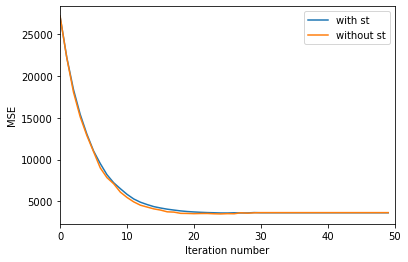

In [9]:
# График

plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), test_errors, label = 'with st')
plt.plot(list(range(n_trees)), test_errors2, label = 'without st')
plt.legend(loc='upper right')
plt.show()

3. *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

In [10]:
def gb_predict(X, trees_list, eta):
        
    predictions = np.array([sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X])

    return predictions

def gb_predict_opt(X, trees_list, eta):
    
    predictions = np.array([np.sum([eta * alg.predict([x])[0] for alg in np.array(trees_list)]) for x in X])
    
    return predictions

In [11]:
# Предыдущая версия

%time
gb_predict(X_train, trees, eta = 0.04)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


array([107.38473043,  37.36527605,  71.26741765, 117.67364805,
        36.16068556,  50.84676971,  25.68029844,  58.83272105,
        54.56015952,  35.46963345,  51.67174729, 101.46493873,
       100.84581066,  49.12387061, 116.37205977,  47.94916515,
        36.8139927 , 152.45774823, 103.3977793 ,  27.58207861,
        35.652886  ,  44.00615971, 134.63590394,  78.96113324,
        98.04320031,  62.00581069,  92.68958767, 105.22480922,
        38.51379756,  50.63700752,  74.84167552,  34.57008173,
        53.44791499,  62.71763278,  77.4958909 ,  30.92714634,
        34.40541995,  27.04484874,  31.99008997,  45.84074388,
        91.05876182, 112.12556846,  69.77002959,  38.66656452,
        95.64550925, 103.62395859,  89.06858487, 105.21772404,
        36.50798782,  27.5797482 ,  37.20818276,  60.56423961,
        46.47058072,  63.45899721,  87.39249958, 110.86429241,
        89.95097572,  30.42465402,  19.62081296,  57.2864256 ,
        38.6076544 ,  81.49314736,  72.11504088,  73.36

In [12]:
# Новая версия

%time 
gb_predict_opt(X_train, trees, eta = 0.04)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


array([107.38473043,  37.36527605,  71.26741765, 117.67364805,
        36.16068556,  50.84676971,  25.68029844,  58.83272105,
        54.56015952,  35.46963345,  51.67174729, 101.46493873,
       100.84581066,  49.12387061, 116.37205977,  47.94916515,
        36.8139927 , 152.45774823, 103.3977793 ,  27.58207861,
        35.652886  ,  44.00615971, 134.63590394,  78.96113324,
        98.04320031,  62.00581069,  92.68958767, 105.22480922,
        38.51379756,  50.63700752,  74.84167552,  34.57008173,
        53.44791499,  62.71763278,  77.4958909 ,  30.92714634,
        34.40541995,  27.04484874,  31.99008997,  45.84074388,
        91.05876182, 112.12556846,  69.77002959,  38.66656452,
        95.64550925, 103.62395859,  89.06858487, 105.21772404,
        36.50798782,  27.5797482 ,  37.20818276,  60.56423961,
        46.47058072,  63.45899721,  87.39249958, 110.86429241,
        89.95097572,  30.42465402,  19.62081296,  57.2864256 ,
        38.6076544 ,  81.49314736,  72.11504088,  73.36